In [1]:
import torchvision
import torch.nn as nn
import torch.nn.functional as nnf
import torch
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.functional import to_tensor, normalize
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision import transforms, models
from torchvision.datasets import Food101
from torchvision.models import ResNet50_Weights


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

def test_acc(net: nn.Module, test_loader: DataLoader):

	net.to(device)
	net.eval()
	
	total = 0
	correct = 0

	for images, labels in test_loader:
		images, labels = images.to(device), labels.to(device)
		total += labels.size(0)

		outputs = net(images)
		_, predicted = torch.max(outputs, 1)
		correct += (predicted == labels).sum().item()

	return correct / total * 100

def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer, train_dataset_length):

	losses = []
	accuracies = []

	net.to(device)

	for e in range(epochs):
		net.train()
		running_loss = 0.0

		for images, labels in train_loader:
			images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

			optimizer.zero_grad()
			outputs = net(images)
			loss = loss_fn(outputs, labels)
			loss.backward()
			optimizer.step()

			running_loss += loss.item() * images.size(0)

		epoch_loss = running_loss / train_dataset_length

		print(f"Loss-ul la finalul epocii {e + 1}: {epoch_loss}")

		acc = test_acc(net, test_loader)
		print(f"Acuratetea la finalul epocii {e + 1} este {acc:.2f}%")

		losses.append(epoch_loss)
		accuracies.append(acc)

		torch.save(net.state_dict(), f'saved_models_triple/epoch{e + 1}.pkl')

	loss_graph(losses)
	accuracy_graph(accuracies)

def loss_graph(losses):
    plt.plot(losses)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

def accuracy_graph(accuracies):
    plt.plot(accuracies)

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()
    
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        resnet = nn.Sequential(*list(resnet.children())[:-1])
        for param in resnet.parameters():
            param.requires_grad = False


        self.model = nn.Sequential(
            resnet,
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 101)
        )

    def forward(self, x):
        return self.model(x)

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


Training started
Loss-ul la finalul epocii 1: 1.6599976058871833
Acuratetea la finalul epocii 1 este 66.48%
Loss-ul la finalul epocii 2: 1.6327395185291178
Acuratetea la finalul epocii 2 este 67.13%
Loss-ul la finalul epocii 3: 1.6150228311205068
Acuratetea la finalul epocii 3 este 67.10%
Loss-ul la finalul epocii 4: 1.5986359260357645
Acuratetea la finalul epocii 4 este 67.28%
Loss-ul la finalul epocii 5: 1.5944221831029004
Acuratetea la finalul epocii 5 este 66.97%
Loss-ul la finalul epocii 6: 1.5957725407817576
Acuratetea la finalul epocii 6 este 67.88%
Loss-ul la finalul epocii 7: 1.580157562167731
Acuratetea la finalul epocii 7 este 68.05%
Loss-ul la finalul epocii 8: 1.572518914421006
Acuratetea la finalul epocii 8 este 67.94%
Loss-ul la finalul epocii 9: 1.563786191707397
Acuratetea la finalul epocii 9 este 67.75%
Loss-ul la finalul epocii 10: 1.5673239113143569
Acuratetea la finalul epocii 10 este 68.23%


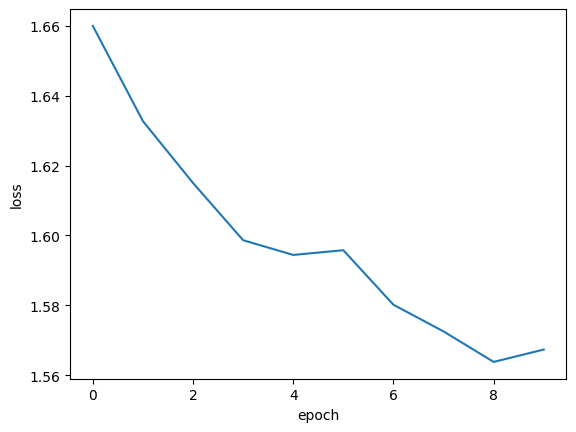

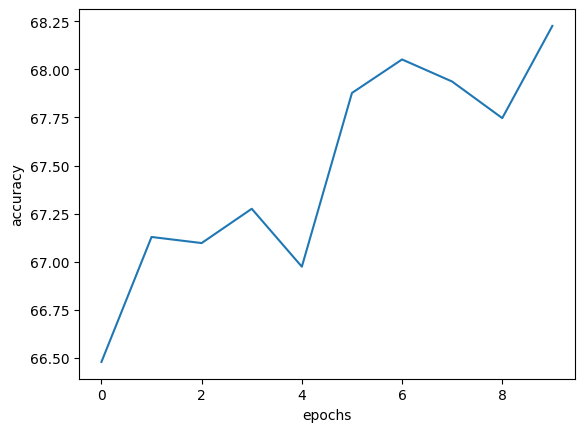

Duration of training: 249.49264710744222


In [3]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets
train_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/Facultate/IAVA/Proiect/Food Classifier Final/datasets/data', split='train', transform=transform, download=True)
test_dataset = Food101(root='C:/Users/Vlad Talpiga.VLR_PROJAMZ/OneDrive - Valrom Industrie SRL/Desktop/Facultate/IAVA/Proiect/Food Classifier Final/datasets/data', split='test', transform=transform, download=True)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = Model()
state_dict = torch.load(f'saved_models_double/epoch7.pkl')
model.load_state_dict(state_dict)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.95, 0.999), weight_decay=0.0001)
 
epochs = 10
start = time.time()
print('Training started')

train_fn(epochs, train_loader, test_loader, model, loss_fn, optimizer, len(train_dataset))

end = time.time()
print(f'Duration of training: {(end - start) / 60}')